In [1]:
from simulation import *
from aesthetics import *
from models import *
from data import *

import glob
import os as os
import re as re
import pandas as pd

%reload_ext autoreload
%autoreload 2
%matplotlib inline
mpl.rc('text', usetex=True)

# Read in results from the torsion scan

In [2]:
df = pd.read_pickle('adk-residues-by-flux.pickle')

In [3]:
print('The total number of torsions is: {}'.format(len(df)))
print('The number of torsions with flux > 1 is: {}'.format(np.sum(df['Flux'].abs() > 1)))
print('The number of torsions with maximum load > 0.01 is: {}'.format(np.sum(df['Max load'].abs() > 0.01)))
print('The number of torsions with maximum power > 0.01 is: {}'.format(np.sum(df['Max power'].abs() > 0.01)))

The total number of torsions is: 903
The number of torsions with flux > 1 is: 1
The number of torsions with maximum load > 0.01 is: 4
The number of torsions with maximum power > 0.01 is: 14


# Setup functions to return flux, load, and power for a given concentration

In [4]:
def get_flux(name, cSubstrate=None):
    this = simulation(data_source = 'adk_md_data')
    this.name = name
    this.load = False
    if cSubstrate:
        this.cSubstrate = cSubstrate
    this.simulate(plot=False)
    return np.mean(this.flux_u + this.flux_b), np.std(this.flux_u + this.flux_b), np.mean(this.flux_ub)

def get_power(name, flux, cSubstrate):
    if flux > 0:
        guess = np.random.uniform(low = 0.000001, high = 0.001)
    else:
        guess = np.random.uniform(high = -0.000001, low = -0.001)
    results = sc.optimize.fmin(power_from_load, x0=guess, args=(name, cSubstrate), 
                                 full_output=True, disp=False)
    max_load = results[0][0]
    max_power = -1 *results[1]
    return max_power, max_load

def power_from_load(load, name, cSubstrate):
    this = simulation(data_source = 'adk_md_data')
    this.name = name
    this.load = True
    this.load_slope = load
    if cSubstrate:
        this.cSubstrate = cSubstrate     
    this.simulate()
    flux = np.mean(this.flux_u + this.flux_b)
    power = flux * load
    del this
    return -1 * power

In [5]:
calculation = False
concentration_scan = pd.DataFrame()
if calculation:
    adk_dir = '../../md-data/adenylate-kinase/'
    adk_unbound_files = sorted(glob.glob(adk_dir + 'AdKDihedHist_apo-4ake/' + '*'))
    names = []
    for file in range(len(adk_unbound_files)):
        name = os.path.splitext(os.path.basename(adk_unbound_files[file]))[0]
        name = re.search('^[^_]*', name).group(0)        
        if re.search('omega*', name):
            continue
        if re.search('chi3ASN*', name):
            continue
        if re.search('chi5LYS*', name):
            continue
        names.append(name)

    for concentration in np.arange(0, 6, 0.2):
        print(concentration)
        adk_dir = '../../md-data/adenylate-kinase/'
        adk_unbound_files = sorted(glob.glob(adk_dir + 'AdKDihedHist_apo-4ake/' + '*'))

        for name in names:
            cSubstrate = 10**-concentration
            flux, flux_std, sloshing = get_flux(name, cSubstrate)
            max_power, max_load = get_power(name, flux, cSubstrate)

            concentration_scan = concentration_scan.append(pd.DataFrame({'Flux': flux,
                                    'Intersurface flux': sloshing,
                                    'File': name,
                                    'Power @ concentration': max_power,
                                    'Load @ concentration' : max_load,
                                    'Concentration' : round(concentration, 1), 
                                    'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                    }, index=[0]), ignore_index=True)
    concentration_scan.to_pickle('adk-concentration-scan.pickle')
else:
    concentration_scan = pd.read_pickle('adk-concentration-scan.pickle')

I meant to do this on dataframe creation but I didn't, so here's how to round the concentration to 2 decimal places.

In [6]:
concentration_scan = concentration_scan.round({'Concentration': 2,})

In [7]:
concentration_scan.head()
concentration_scan.tail()

,Concentration,File,Flux,Intersurface flux,Load @ concentration,Power @ concentration,ResID
27085,5.8,psiVAL205,-0.000370,-2.307271e-13,-0.000774,-6.475946e-07,205
27086,5.8,psiVAL39,0.000418,-7.633927e-14,0.000365,-1.262572e-07,39
27087,5.8,psiVAL59,-0.000099,-7.667031e-03,-0.000118,1.643697e-09,59
27088,5.8,psiVAL64,0.000002,3.409034e-10,0.000170,-4.492352e-08,64
27089,5.8,psiVAL68,0.000414,1.603473e-13,0.000216,-5.737494e-09,68


In [84]:
df = concentration_scan
df[['ResID']] = df[['ResID']].apply(pd.to_numeric)

In [92]:
df[(df['ResID'] == 11) & (df['Concentration'] == 0.0)]['Flux']

0      -0.194833
477     0.005024
690    21.024735
Name: Flux, dtype: float64

# Next, write out intrasurface and intersurface flux to Chimera, and render!

In [93]:
def df_to_chimera(df, file, attribute_label, attribute_name):
    f = open(file, 'w')
    f.write('attribute: {}\n'.format(attribute_label))
    f.write('match mode: any\n')
    f.write('recipient: residues\n')
    for i in range(1, max(df['ResID'].astype(int))):

        x = df[(df['ResID'] == i) & (df['Concentration'] == 3.0)][str(attribute_name)]
        value = max(abs(x))
        f.write('\t:{}\t{}\n'.format(i, value))
    f.close()

In [94]:
df_to_chimera(df, 'adk-residues-by-flux.dat', 'Flux', 'Flux')

In [95]:
df_to_chimera(df, 'adk-residues-by-intersurfaceflux.dat', 'Intersurface flux', 'Intersurface flux')

# For each concentration, print out the file with maximum flux, maximum load, and maximum power.

In [129]:
concentrations = sorted(set(df['Concentration'].values))

# This should be absolute value, but it's not.

print('Intrasurface flux maxima')
for concentration in concentrations:
    maximum_flux = df[(df['Concentration'] == round(concentration, 2))]['Flux'].max()
    maximum_flux_file = df[(df['Flux'] == maximum_flux) & (df['Concentration'] == concentration)]['File'].values[0]
    print('{}\t{}\t{}'.format(concentration, maximum_flux_file, maximum_flux))

print('Intersurface flux maxima')
for concentration in concentrations:
    maximum_intersurfaceflux = df[(df['Concentration'] == round(concentration, 2))]['Intersurface flux'].max()
    maximum_intersurfaceflux_file = df[(df['Intersurface flux'] == maximum_intersurfaceflux) & (df['Concentration'] == concentration)]['File'].values[0]
    print('{}\t{}\t{}'.format(concentration, maximum_intersurfaceflux_file, maximum_intersurfaceflux))

print('Load maxima')
for concentration in concentrations:
    maximum_load = df[(df['Concentration'] == round(concentration, 2))]['Load @ concentration'].max()
    maximum_load_file = df[(df['Load @ concentration'] == maximum_load) & (df['Concentration'] == concentration)]['File'].values[0]
    print('{}\t{}\t{}'.format(concentration, maximum_load_file, maximum_load))

print('Power maxima')
for concentration in concentrations:
    maximum_power = df[(df['Concentration'] == round(concentration, 2))]['Power @ concentration'].max()
    maximum_power_file = df[(df['Power @ concentration'] == maximum_power) & (df['Concentration'] == concentration)]['File'].values[0]
    print('{}\t{}\t{}'.format(concentration, maximum_power_file, maximum_power))



Intrasurface flux maxima
0.0	psiSER41	89.48783734542697
0.2	psiSER41	89.29281262270347
0.4	psiSER41	88.96678242240861
0.6	psiSER41	88.44176659518054
0.8	psiSER41	87.61681554182616
1.0	psiSER41	86.33535477729855
1.2	psiSER41	84.3758711951147
1.4	psiSER41	81.44518517190366
1.6	psiSER41	77.19540164487994
1.8	psiSER41	71.29762996042543
2.0	psiSER41	63.5972045409216
2.2	chi2PHE19	55.754976826057586
2.4	chi2PHE19	53.934000144269156
2.6	chi2PHE19	51.27841867846025
2.8	chi2PHE19	47.565832642926885
3.0	chi2PHE19	42.66939315571387
3.2	chi2PHE19	36.68502213688141
3.4	chi2PHE19	30.012969074528275
3.6	chi2PHE19	23.297475818271536
3.8	chi2PHE19	17.198366617506448
4.0	chi2PHE19	12.154307186226166
4.2	chi2PHE19	8.297984182975293
4.4	chi2PHE19	5.5213007032953705
4.6	chi2PHE19	3.6080101064561556
4.8	chi2PHE19	2.3285895835145007
5.0	chi2PHE19	1.4912625272584894
5.2	chi2PHE19	0.9501251333253701
5.4	chi2PHE19	0.6020850447822037
5.6	chi2PHE19	0.38194483894788694
5.8	chi2PHE19	0.24168954522338026
Intersurfac

# Why is psiSER41 not the highest load supporter at cSubstrate = 1.8?

In [131]:
df[df['File'] == 'psiSER41']

,Concentration,File,Flux,Intersurface flux,Load @ concentration,Power @ concentration,ResID
864,0.0,psiSER41,89.487837,17.811964,1.185388,52.786372,41
1767,0.2,psiSER41,89.292813,17.773537,1.184551,52.668507,41
2670,0.4,psiSER41,88.966782,17.709009,1.182265,52.470806,41
3573,0.6,psiSER41,88.441767,17.604563,1.182572,52.152939,41
4476,0.8,psiSER41,87.616816,17.440561,1.183806,51.651993,41
5379,1.0,psiSER41,86.335355,17.185521,1.182745,50.873197,41
6282,1.2,psiSER41,84.375871,16.795585,1.179889,49.681294,41
7185,1.4,psiSER41,81.445185,16.212176,1.175330,47.895755,41
8088,1.6,psiSER41,77.195402,15.366203,1.171668,45.299324,41
8991,1.8,psiSER41,71.297630,14.192381,0.000008,0.000553,41


C                         +1.00e+06  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +3.12e+02  second**-1
[S]                       +1.58e-02  M         
dt                        +1.00e-12  second**-1
-----------------         ---------  --------- 
Intrasurface flux         +7.13e+01  cycle second**-1
Intersurface flux         +1.42e+01  cycle second**-1


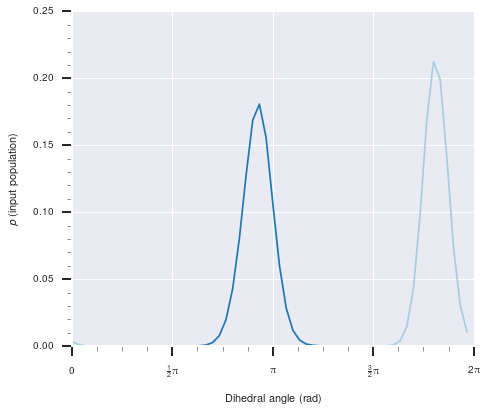

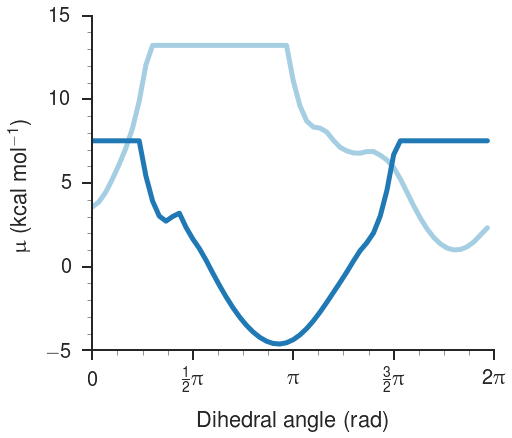

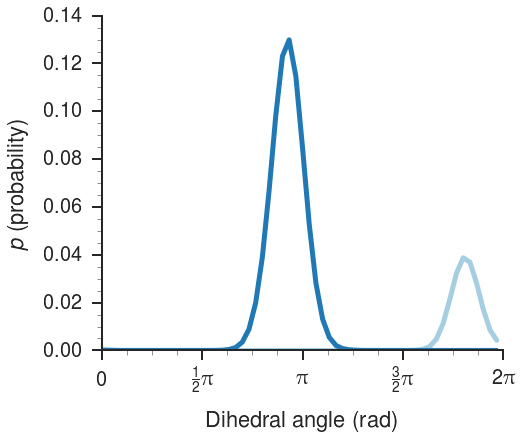

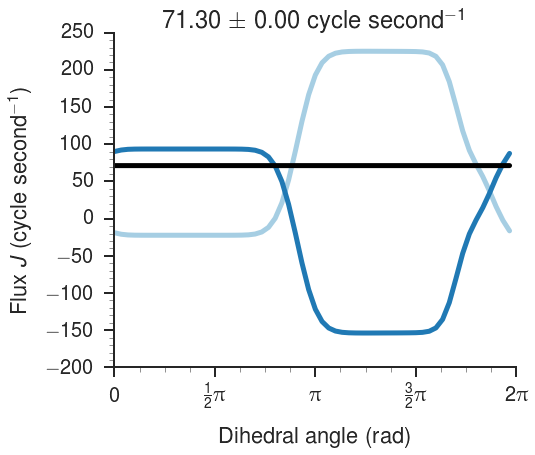

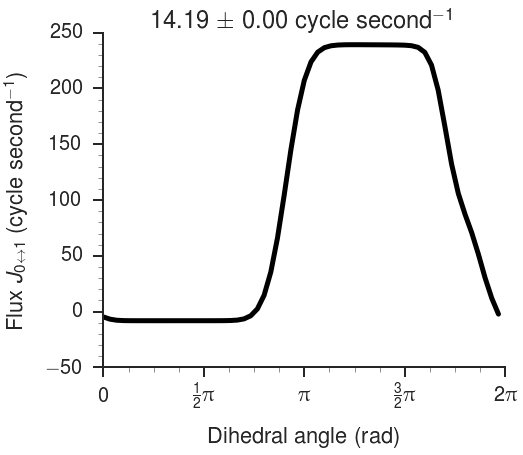

In [132]:
this = simulation(data_source='adk_md_data')
this.name = 'psiSER41'
this.cSubstrate = 10**-1.8
this.simulate(plot=True)

/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


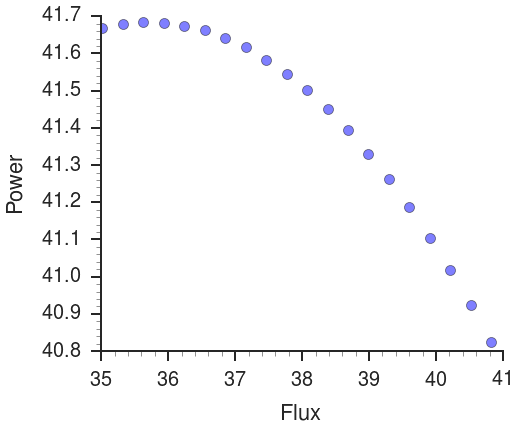

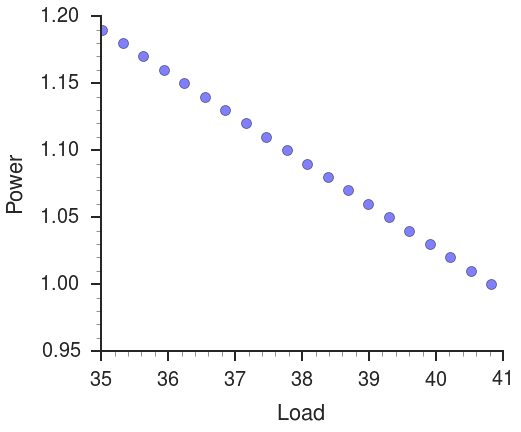

In [135]:
fluxes = []
powers = []
loads = []

for load_slope in np.arange(1, 1.2, 0.01):
    this = simulation(data_source='adk_md_data')
    this.name = 'psiSER41'
    this.cSubstrate = 10**-1.8
    this.load = True
    this.load_slope = load_slope
    this.simulate()
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    powers.append(load_slope * np.mean(this.flux_u + this.flux_b))
    loads.append(load_slope)

ax = aesthetics.generic_plot(fluxes, powers, 'Flux', 'Power', scientific=True)
ax = aesthetics.generic_plot(fluxes, loads, 'Load', 'Power', scientific=True)



## Aha, power should be 41, and load should be 1.15ish.

/mnt/639f049e-1c5c-4215-bb93-e396da93aa2b/projects/nonequilibrium/code/SG-model-v2/simulation.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


C                         +1.00e+06  second**-1
D                         +3.00e+12  degrees**2 second**-1
k_{cat}                   +3.12e+02  second**-1
[S]                       +1.00e+01  M         
dt                        +1.00e-12  second**-1
-----------------         ---------  --------- 
Intrasurface flux         +8.93e+01  cycle second**-1
Intersurface flux         +1.78e+01  cycle second**-1


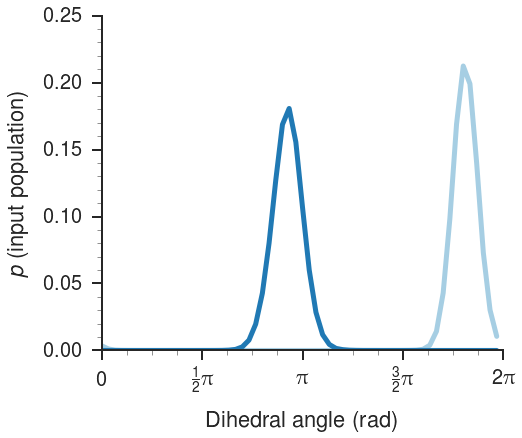

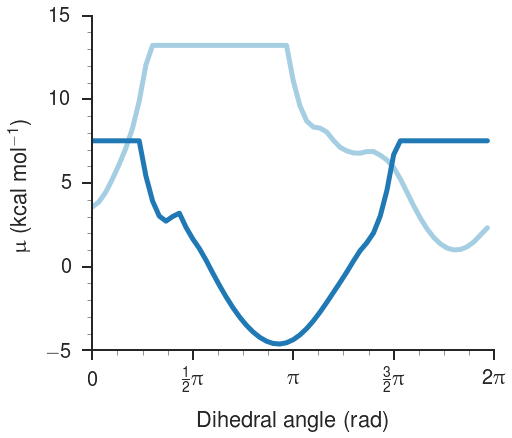

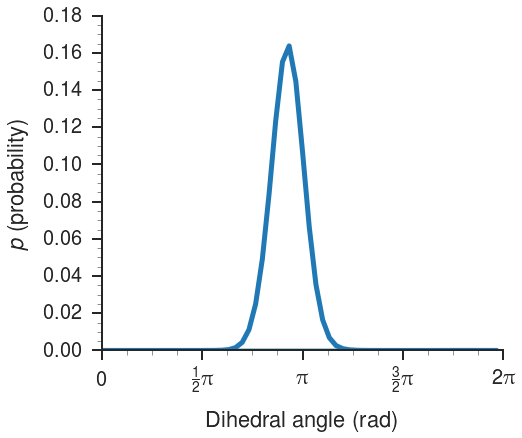

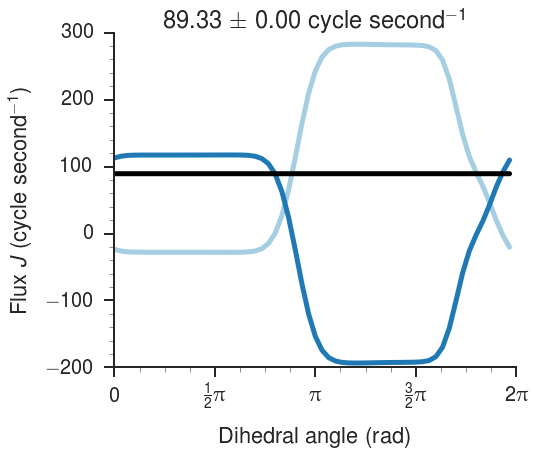

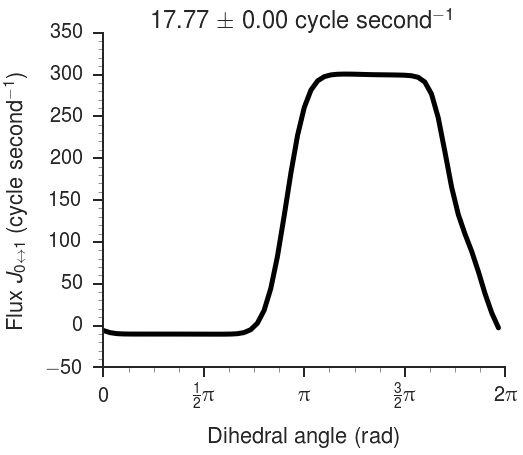

In [11]:

this = simulation(data_source='adk_md_data')
this.name = 'psiSER41'
this.cSubstrate = 10
this.simulate(plot=True)

In [1]:
concentrations = sorted(set(df['Concentration'].values))

for concentration in concentrations:
    maximum_flux = df[(df['Concentration'] == round(concentration, 2))]['Flux'].max()


NameError: name 'df' is not defined